<a href="https://colab.research.google.com/github/archipelcitoyen/TAS_2026/blob/main/TAS_INSEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ANALYSE DES CARREAUX INSEE 2019 POUR LE CIBLAGE DU PORTE-À-PORTE - MUNICIPALES TOULOUSE 2026 - ARCHIPEL CITOYEN

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import requests
import zipfile
#import io
import os
import fiona
import random
from urllib.request import urlretrieve
from shapely.geometry import box, Point
#import urllib.request
import geopandas as gpd
import folium
from folium import Choropleth, LayerControl
import branca.colormap as cm

In [2]:
# Configuration
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [ ]:
def telecharger_donnees_insee():
    """Télécharge les données carroyées de l'INSEE à 200m"""
    
    print("Téléchargement des données carroyées INSEE 200m...")
    
    # URL de téléchargement des données carroyées 200m les plus récentes (2019)
    url_carreaux = "https://www.insee.fr/fr/statistiques/fichier/7655475/Filosofi2019_carreaux_200m_gpkg.zip"

    # Chemin local pour sauvegarder le fichier zip
    zip_path = os.path.join(DATA_DIR, "Filosofi2019_carreaux_200m_gpkg.zip")
    
    # Télécharger le fichier
    urlretrieve(url_carreaux, zip_path)
    
    # Extraire le contenu du zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    
    print("Téléchargement et extraction terminés.")

def charger_donnees_insee_local(chemin_geopackage):
    """Charge les données carroyées de l'INSEE à partir d'un fichier geopackage local"""
    
    print(f"Chargement des données carroyées INSEE 200m depuis le fichier local : {chemin_geopackage}")
    
    # Vérification que le fichier existe
    if not os.path.exists(chemin_geopackage):
        raise FileNotFoundError(f"Le fichier {chemin_geopackage} n'existe pas.")
    
    # Chargement du geopackage
    try:
        # Lister les couches disponibles dans le geopackage
        layers = fiona.listlayers(chemin_geopackage)
        print(f"Couches disponibles dans le geopackage : {layers}")
        
        # Charger la première couche (ou spécifier le nom si connu)
        layer_name = layers[0]
        carreaux_gdf = gpd.read_file(chemin_geopackage, layer=layer_name)
        
        print(f"Données chargées avec succès. {len(carreaux_gdf)} carreaux trouvés.")
        print(f"CRS des données : {carreaux_gdf.crs}")
        print(f"Colonnes disponibles : {carreaux_gdf.columns.tolist()}")
        
        return carreaux_gdf
    
    except Exception as e:
        print(f"Erreur lors du chargement du geopackage : {e}")
        raise

In [ ]:
def decouper_carreaux_toulouse(carreaux_gdf, toulouse_gdf):
    """Découpe les carreaux selon les limites de Toulouse"""
    print("Découpage des carreaux selon les limites de Toulouse...")
    # Reprojection des limites de Toulouse dans le même CRS que les carreaux
    toulouse_reproj = toulouse_gdf.to_crs(carreaux_gdf.crs)
    # Découpage des carreaux selon les limites de Toulouse
    carreaux_toulouse = gpd.sjoin(carreaux_gdf, toulouse_reproj, how="inner", predicate="intersects")
    # Sauvegarde des carreaux de Toulouse
    carreaux_toulouse_path = os.path.join(DATA_DIR, "carreaux_toulouse.gpkg")
    carreaux_toulouse.to_file(carreaux_toulouse_path, driver="GPKG")
    print(f"Données carroyées découpées. {len(carreaux_toulouse)} carreaux trouvés pour Toulouse.")
    return carreaux_toulouse

def calculer_indicateurs(carreaux):
    """
    Calcule les indicateurs de précarité pour chaque carreau.
    """

    # Pourcentage de ménages pauvres
    if 'men_pauv' in carreaux.columns and 'men' in carreaux.columns:
        carreaux['pct_men_pauvres'] = (carreaux['men_pauv'] / carreaux['men']) * 100
    else:
        carreaux['pct_men_pauvres'] = np.nan

    # Pourcentage de familles monoparentales
    if 'men_fmp' in carreaux.columns and 'men' in carreaux.columns:
        carreaux['pct_men_monoparentales'] = (carreaux['men_fmp'] / carreaux['men']) * 100
    else:
        carreaux['pct_men_monoparentales'] = np.nan

    # Pourcentage de jeunes adultes
    if 'ind_18_24' in carreaux.columns and 'ind' in carreaux.columns:
        carreaux['pct_ind_18_24'] = (carreaux['ind_18_24'] / carreaux['ind']) * 100
    else:
        carreaux['pct_ind_18_24'] = np.nan

    # Pourcentage de logement social
    if 'log_soc' in carreaux.columns and 'men' in carreaux.columns:
        carreaux['pct_log_soc'] = (carreaux['log_soc'] / (carreaux['log_av45'] + carreaux['log_45_70'] + carreaux['log_70_90'] + carreaux['log_ap90'] + carreaux['log_inc'])) * 100
    else:
        carreaux['pct_log_soc'] = np.nan

    # Pourcentage de ménages en logements collectifs
    if 'men_coll' in carreaux.columns and 'men' in carreaux.columns:
        carreaux['pct_men_coll'] = (carreaux['men_coll'] / carreaux['men']) * 100
    else:
        carreaux['pct_men_coll'] = np.nan

    # Pourcentage de locataires
    if 'men_prop' in carreaux.columns and 'men' in carreaux.columns:
        carreaux['pct_locataires'] = (1 - carreaux['men_prop'] / carreaux['men']) * 100
    else:
        carreaux['pct_locataires'] = np.nan

    return carreaux

def normaliser_indicateurs(carreaux):
    """
    Normalise les indicateurs de précarité pour chaque carreau.
    """
    def normaliser(serie):
        min_val = serie.min()
        max_val = serie.max()
        if pd.notnull(min_val) and pd.notnull(max_val) and max_val > min_val:
            return (serie - min_val) / (max_val - min_val)
        else:
            return pd.Series([0] * len(serie), index=serie.index)

    # Normalisation
    carreaux['norm_pct_men_pauvres'] = normaliser(carreaux['pct_men_pauvres'])
    carreaux['norm_pct_men_monoparentales'] = normaliser(carreaux['pct_men_monoparentales'])
    carreaux['norm_pct_ind_18_24'] = normaliser(carreaux['pct_ind_18_24'])
    carreaux['norm_pct_log_soc'] = normaliser(carreaux['pct_log_soc'])
    carreaux['norm_pct_men_coll'] = normaliser(carreaux['pct_men_coll'])
    carreaux['norm_pct_locataires'] = normaliser(carreaux['pct_locataires'])
    #carreaux['norm_revenu_moyen'] = 1 - normaliser(carreaux['revenu_moyen'])  # Inversion car revenu élevé = moins de précarité
    #carreaux['norm_pct_bas_revenus'] = normaliser(carreaux['pct_bas_revenus'])
    return carreaux


def calculer_indicateur_composite(carreaux):
    """
    Calcule l'indicateur composite d'invisibilisation pour chaque carreau.
    """
    # Pondérations
    poids_bruts = {
        'norm_pct_men_pauvres': 3,
        'norm_pct_men_monoparentales': 2,
        'norm_pct_ind_18_24': 1,
        'norm_pct_log_soc': 1,
        'norm_pct_men_coll': 1,
        'norm_pct_locataires': 1
    }
    somme_poids = sum(poids_bruts.values())
    poids = {variable: poids / somme_poids for variable, poids in poids_bruts.items()}

    # Calcul de l'indicateur composite
    indicateur = pd.Series(0, index=carreaux.index, dtype=float)
    poids_total = 0

    for indicateur_nom, p in poids.items():
        if indicateur_nom in carreaux.columns and not carreaux[indicateur_nom].isnull().all():
            indicateur += p * carreaux[indicateur_nom]
            poids_total += p

    if poids_total > 0:
        carreaux['indicateur_invisibilisation'] = indicateur / poids_total
    else:
        carreaux['indicateur_invisibilisation'] = 0

    return carreaux

def filtrer_carreaux(carreaux, seuil_population=20):
    """
    Filtre les carreaux ayant une population inférieure au seuil spécifié.
    """
    if 'ind' in carreaux.columns:
        return carreaux[carreaux['ind'] >= seuil_population]
    else:
        return carreaux

def random_point_in_polygon(polygon):
    min_x, min_y, max_x, max_y = polygon.bounds
    while True:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            return point

In [ ]:
telecharger_donnees_insee()
chemin_geopackage = os.path.join(DATA_DIR, "Filosofi2019_carreaux_200m_gpkg","carreaux_200m_met.gpkg")
carreaux_gdf = charger_donnees_insee_local(chemin_geopackage)
carreaux_toulouse = decouper_carreaux_toulouse(carreaux_gdf, toulouse_gdf)

In [ ]:
gdf = gpd.read_file(os.path.join(DATA_DIR, "carreaux_toulouse.gpkg"))
print("Calcul de l'indicateur d'invisibilisation...")
gdf = calculer_indicateurs(gdf)
gdf = normaliser_indicateurs(gdf)
gdf = calculer_indicateur_composite(gdf)
gdf = filtrer_carreaux(gdf)
#gdf.to_file(chemin_fichier, driver="GPKG")


Calcul de l'indicateur d'invisibilisation...


<Axes: >

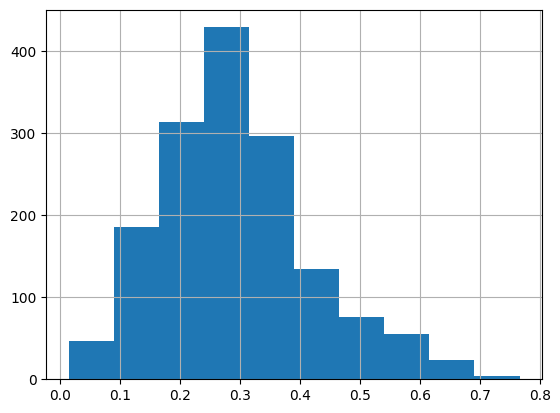

In [7]:
gdf['indicateur_invisibilisation'].hist()

In [8]:
# Filtrer les carreaux avec un indicateur de précarité supérieur ou égal à 0.75
seuil = 0.5
gdf_invisibilise = gdf[gdf['indicateur_invisibilisation'] >= seuil].copy()
print(len(gdf_invisibilise))

110


In [9]:
gdf_sample = gdf_invisibilise.sample(n=10, random_state=42).copy()
print(len(gdf_sample))

10


In [15]:
gdf_sample['random_point'] = gdf_sample.geometry.apply(random_point_in_polygon)
gdf_sample['random_point'] = gdf_sample['random_point'].to_crs(epsg=4326)

In [ ]:
from folium import FeatureGroup, GeoJson, Marker, Icon

# Vérifier et définir la projection si nécessaire
if gdf.crs is None:
    gdf.set_crs(epsg=2154, inplace=True)  # Lambert-93, projection courante en France

m = folium.Map(location=[43.6045, 1.4442], zoom_start=12, tiles=None)
folium.TileLayer(
    tiles='CartoDB positron',
    name='Fond de carte',
    control=False
).add_to(m)

colormap = cm.linear.YlOrRd_09.scale(0, 1)
colormap.caption = 'Indicateur normalisé'
colormap.add_to(m)

# Chargement des données
gdf = gpd.read_file(chemin_fichier) #gpd.read_file("carreaux_toulouse_precarite.gpkg")

# Liste des variables à visualiser
variables = {
    "Ménages pauvres": 'norm_pct_men_pauvres',
    "Familles monoparentales": 'norm_pct_men_monoparentales',
    "Individus entre 18 et 24 ans": 'norm_pct_ind_18_24',
    "Logements sociaux": 'norm_pct_log_soc',
    "Ménages en logements collectifs": 'norm_pct_men_coll',
    "Taux de locataires": 'norm_pct_locataires',
    "➡️ Indicateur d'invisibilisation": "indicateur_invisibilisation"
}

for nom_couche, colonne in variables.items():
    fg = folium.FeatureGroup(name=nom_couche, show=(colonne == "indicateur_invisibilisation"))
    folium.GeoJson(
        gdf,
        style_function=lambda feature, col=colonne: {
            'fillColor': colormap(feature['properties'][col]) if feature['properties'][col] is not None else '#gray',
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7
        },
        tooltip=folium.GeoJsonTooltip(fields=[colonne], aliases=[nom_couche])
    ).add_to(fg)
    fg.add_to(m)

# Couche des carreaux sélectionnés
fg_precaires = FeatureGroup(name="✅ Carreaux ciblés", show=False)
GeoJson(
    gdf_invisibilise,
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=['indicateur_invisibilisation'], aliases=["Indicateur d'invibilisation"])
).add_to(fg_precaires)
fg_precaires.add_to(m)

# Couche des points aléatoires
fg_points = FeatureGroup(name="🎯 Points tirés au sort", show=True)
for idx, row in gdf_sample.iterrows():
    lon, lat = row['random_point'].x, row['random_point'].y
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='orange', icon='bullseye', prefix='fa'),
        popup=f"Point tiré au sort"
    ).add_to(fg_points)
fg_points.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("carte_invisibilisation_toulouse.html")
